In [8]:
# Import of relevant packages

#pip install jupyter pandas plotly
# pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pickle


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, accuracy_score, precision_recall_curve, recall_score, precision_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Set random seed 
RSEED = 42

# make sure all the warnings show at every instance:
import warnings
warnings.filterwarnings('ignore')

# plot style
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.facecolor':'white'})




## Load Test and Train Data

In [9]:
# load Train data
Train_data = pd.read_csv('/Users/erdem/neuefische/ML-projects/data/Train.csv')
# load Test data
Test_data = pd.read_csv('/Users/erdem/neuefische/ML-projects/data/Test.csv')
# Variable Definition
VariableDefinition = pd.read_csv('/Users/erdem/neuefische/ML-projects/data/VariableDefinitions.csv')
VariableDefinition


,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


# Label Encoder

In [10]:
# categorical features encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Train_data['age_group'] = le.fit_transform(Train_data['age_group'])
Train_data['package_transport_int'] = le.fit_transform(Train_data['package_transport_int'])
Train_data['package_accomodation'] = le.fit_transform(Train_data['package_accomodation'])
Train_data['package_food'] = le.fit_transform(Train_data['package_food'])
Train_data['package_transport_tz'] = le.fit_transform(Train_data['package_transport_tz'])
Train_data['package_sightseeing'] = le.fit_transform(Train_data['package_sightseeing'])
Train_data['package_guided_tour'] = le.fit_transform(Train_data['package_guided_tour'])
Train_data['package_insurance'] = le.fit_transform(Train_data['package_insurance'])
Train_data['first_trip_tz'] = le.fit_transform(Train_data['first_trip_tz'])
Train_data['country'] = le.fit_transform(Train_data['country'])
columns_to_transform = ['tour_arrangement','travel_with','purpose','main_activity','info_source','most_impressing','payment_mode']
data = pd.get_dummies( Train_data,columns = columns_to_transform,drop_first=True)

## Rename columns

In [11]:
data.columns = [c.lower() for c in data.columns]
# make a list column names
cols = data.columns.tolist()
# replace space with _
cols = [col.replace(' ', '_') for col in cols]
cols = [col.replace('/', '_') for col in cols]
cols = [col.replace(',', '_') for col in cols]
# reassign new column names to dataframe
data.columns = cols

### Binned Total_cost and fitted

In [12]:
labels = [0,Train_data['total_cost'].median(), Train_data['total_cost'].max()]         # 2 classes
#labels = np.linspace(0, Train_data['total_cost'].max(), num = 6)                    # 5 classes
Train_data['total_cost_binned'] = pd.cut(Train_data['total_cost'], bins=labels)
Train_data['total_cost_binned'] = LabelEncoder().fit_transform(Train_data['total_cost_binned'])
Train_data['total_cost_binned'].value_counts()

0    2409
1    2400
Name: total_cost_binned, dtype: int64

In [13]:
# Define predictors and target variable
X = Train_data.drop(['total_cost', 'total_cost_binned', 'ID'], axis=1)
y = Train_data['total_cost_binned']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 4809 observations in our dataset and 21 features
Our target vector has also 4809 values


## Train-Test-Split

In [14]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=RSEED)

In [15]:
#pip install -U imbalanced-learn

# from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
# X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

## Categorical vs numerical variables

In [16]:
# Creating list for categorical predictors/features 
# (dates are also objects so if you have them in your data you would deal with them first)
cat_features = list(X.columns[X.dtypes==object])
# Creating list for numerical predictors/features
# Since 'Survived' is our target variable we will exclude this feature from this list of numerical predictors 
num_features = list(X.columns[X.dtypes!=object])


## Preprocessing Pipeline

In [17]:
#from sklearn.pipeline import Pipeline

# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

num_pipeline_sex = Pipeline([
    ('imputer_num_sex', SimpleImputer(strategy='most_frequent')),
    ('std_scaler_sex', StandardScaler())
])


# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    ('num', num_pipeline, num_features),
    ('num_sex', num_pipeline_sex, ["total_female", 'total_male'])
])

## Evaluation metric

In [19]:
# Calculate metric
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """Calculate and print out MAE, RMSE and R2 for train and test data

    Args:
        y_train (array): true values of y_train
        y_pred_train (array): predicted values of model for y_train
        y_test (array): true values of y_train
        y_pred_test (array): predicted values of model for y_test
    """

    print("Metrics on training data") 
    mae = np.sqrt(mean_absolute_error(y_train,y_pred_train))
    maep = mean_absolute_percentage_error(y_train,y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))
    r2 = r2_score(y_train,y_pred_train)
    print("MAE:", round(mae, 3))
    print("MAPE:", round(maep, 3))
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)
    
    # Calculate metric
    print("Metrics on test data")  
    maep = mean_absolute_percentage_error(y_test,y_pred_test)
    mae = np.sqrt(mean_absolute_error(y_test, y_pred_test))
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    # you can get the same result with this line:
    # rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))

    r2 = r2_score(y_test,y_pred_test)
    print("MAE:", round(mae, 3))
    print("MAPE:", round(maep, 3))
    print("RMSE:", round(rmse, 3))
    print("---"*10)

## Fit Models for ML Model
#### 1) LogisticRegression

In [20]:
# Building a full pipeline with our preprocessor and a Logistic Regression
pipe_log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

In [21]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_log_reg, X_train, y_train, cv=5)

In [22]:
y_test_predicted = cross_val_predict(pipe_log_reg, X_test, y_test, cv=5)

In [23]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       482
           1       0.80      0.80      0.80       480

    accuracy                           0.80       962
   macro avg       0.80      0.80      0.80       962
weighted avg       0.80      0.80      0.80       962



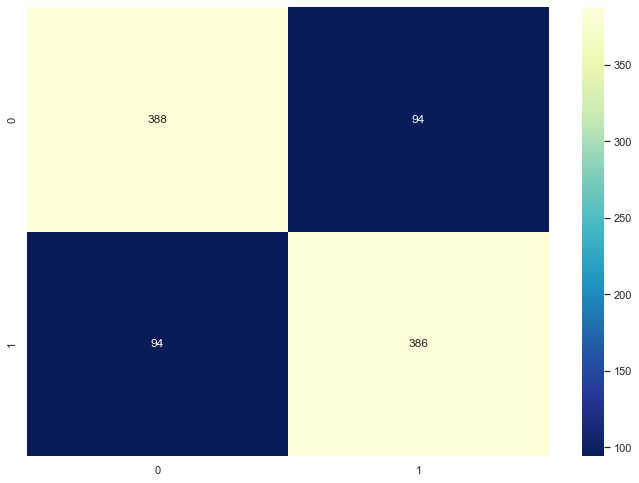

In [24]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### 2) XGBoost

In [25]:
# Building a full pipeline with our preprocessor and a XGBClassifier
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(silent=True, verbosity=0, random_state=RSEED, use_label_encoder=False))
])

In [26]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)

In [27]:
y_test_predicted = cross_val_predict(pipe_xgb, X_test, y_test, cv=5)

In [28]:
# Calculating the accuracy for the XGB Classifier 
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       482
           1       0.79      0.83      0.81       480

    accuracy                           0.81       962
   macro avg       0.81      0.81      0.81       962
weighted avg       0.81      0.81      0.81       962



In [29]:
# Gridsearch
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'xgb') in our pipeline 
# we have to add 'xgb__' infront of the corresponding hyperparameters. 
param_xgb = {'xgb__min_child_weight': [1, 5, 10],
            'xgb__gamma': [0.5, 1, 1.5, 2, 5],
            'xgb__subsample': [0.6, 0.8, 1.0],
            'xgb__colsample_bytree': [0.6, 0.8, 1.0],
            'xgb__max_depth': [3, 4, 5]
            }

grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb, cv=5, scoring='recall', 
                           verbose=0, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['travel_with',
                                                                          'purpose',
                                                                          'main_ac

In [30]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))
# Save best model (including fitted preprocessing steps) as best_model 
best_model = grid_xgb.best_estimator_

Best score:
0.86
Best parameters:
{'xgb__colsample_bytree': 0.6, 'xgb__gamma': 5, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__subsample': 1.0}


In [31]:
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.81
Recall: 0.83
Precision: 0.80


##### New Treshold

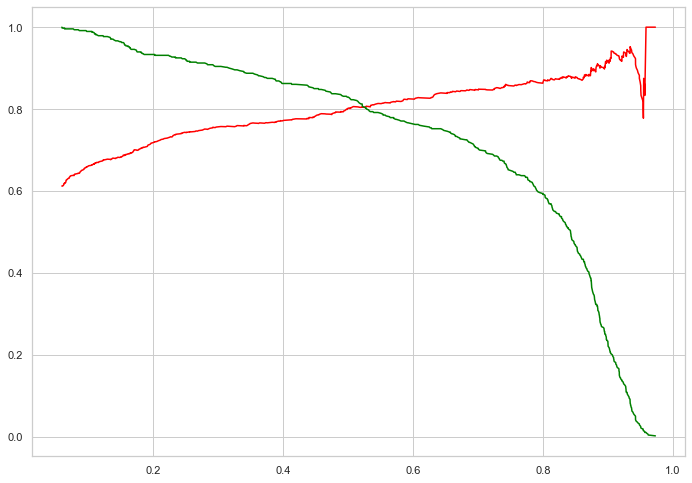

In [32]:
y_scores = grid_xgb.predict_proba(X_test)


precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])

precision = precision[:-1]
recall = recall[:-1]

plt.plot(thresholds,precision, color='red')
plt.plot(thresholds,recall, color='green')
plt.show()

In [33]:
y_pred_new_threshold = (grid_xgb.predict_proba(X_test)[:,1]>=0.4).astype(int)


In [34]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.85      0.75      0.79       482
           1       0.77      0.86      0.81       480

    accuracy                           0.80       962
   macro avg       0.81      0.80      0.80       962
weighted avg       0.81      0.80      0.80       962



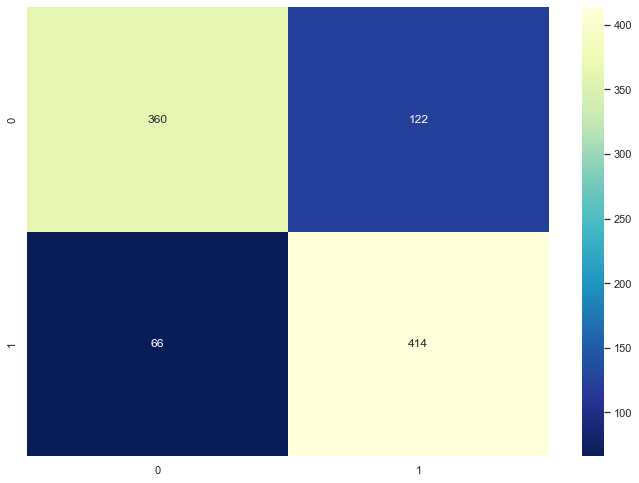

In [35]:
cm = confusion_matrix(y_test, y_pred_new_threshold)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### 3) Random Forest Classifier

In [36]:
# Building a full pipeline with our preprocessor and a Random Forrest Classifier
pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('rfr', RandomForestClassifier(n_estimators=100))
])

In [37]:
# Making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and nr of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe_rfr, X_train, y_train, cv=5)

In [38]:
y_test_predicted = cross_val_predict(pipe_rfr, X_test, y_test, cv=5)

In [39]:
# Calculating the accuracy for the Random Forrest Regressor
print('Cross validation scores:')
print("---"*10)
print(classification_report(y_test, y_test_predicted))

Cross validation scores:
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       482
           1       0.80      0.83      0.81       480

    accuracy                           0.81       962
   macro avg       0.81      0.81      0.81       962
weighted avg       0.81      0.81      0.81       962



### 4) KNN

In [40]:

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier ())
])

In [41]:
y_train_predicted = cross_val_predict(pipe_knn, X_train, y_train, cv=5)

In [42]:
y_test_predicted = cross_val_predict(pipe_knn, X_test, y_test, cv=5)

In [43]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       482
           1       0.77      0.75      0.76       480

    accuracy                           0.76       962
   macro avg       0.76      0.76      0.76       962
weighted avg       0.76      0.76      0.76       962



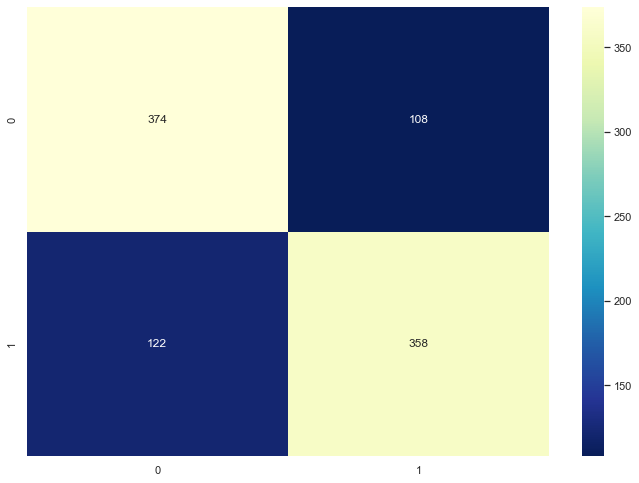

In [44]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### Grid Search CV

In [45]:
n_neighbors = [2, 3, 5, 10]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

grid_list = dict(knn__n_neighbors=n_neighbors,
                      knn__algorithm=algorithm)



grid_search = GridSearchCV(pipe_knn, param_grid = grid_list, n_jobs = 4, cv = 5, scoring='recall') 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['travel_with',
                                                                          'purpose',
                                                                          'main_ac

In [46]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_search.best_score_))
print("Best parameters:\n{}".format(grid_search.best_params_))

Best score:
0.79
Best parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5}


In [47]:
best_model = grid_search.best_estimator_


In [48]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.78
Recall: 0.77
Precision: 0.79


In [49]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       482
           1       0.79      0.77      0.78       480

    accuracy                           0.78       962
   macro avg       0.79      0.78      0.78       962
weighted avg       0.79      0.78      0.78       962



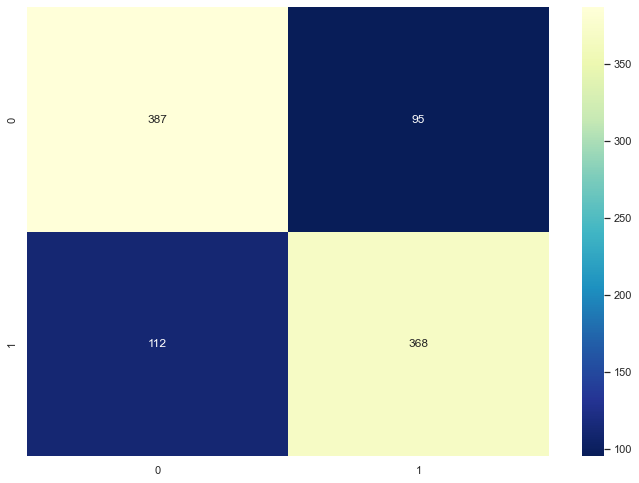

In [50]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### New treshold

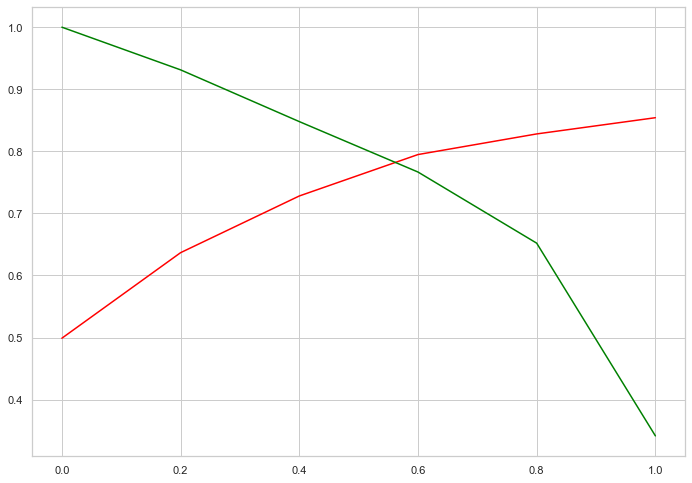

In [51]:
y_scores = grid_search.predict_proba(X_test)


precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])

precision = precision[:-1]
recall = recall[:-1]

plt.plot(thresholds,precision, color='red')
plt.plot(thresholds,recall, color='green')
plt.show()

In [52]:
y_pred_new_threshold = (grid_search.predict_proba(X_test)[:,1]>=0.3).astype(int)


In [53]:
print(classification_report(y_test, y_pred_new_threshold))


              precision    recall  f1-score   support

           0       0.82      0.68      0.75       482
           1       0.73      0.85      0.78       480

    accuracy                           0.77       962
   macro avg       0.77      0.77      0.76       962
weighted avg       0.77      0.77      0.76       962



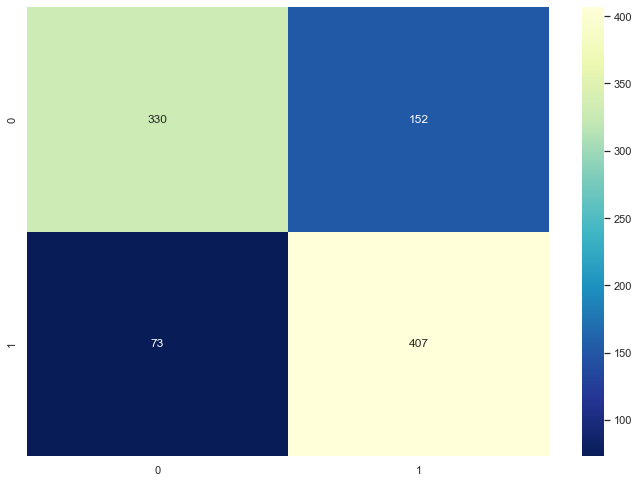

In [54]:
cm = confusion_matrix(y_test, y_pred_new_threshold)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

#### 5) SVC

In [55]:
from sklearn.svm import SVC

# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC ())
])

In [56]:
y_train_predicted = cross_val_predict(pipe_svc, X_train, y_train, cv=5)

In [57]:
y_test_predicted = cross_val_predict(pipe_svc, X_test, y_test, cv=5)

In [58]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       482
           1       0.80      0.84      0.82       480

    accuracy                           0.81       962
   macro avg       0.82      0.82      0.81       962
weighted avg       0.82      0.81      0.81       962



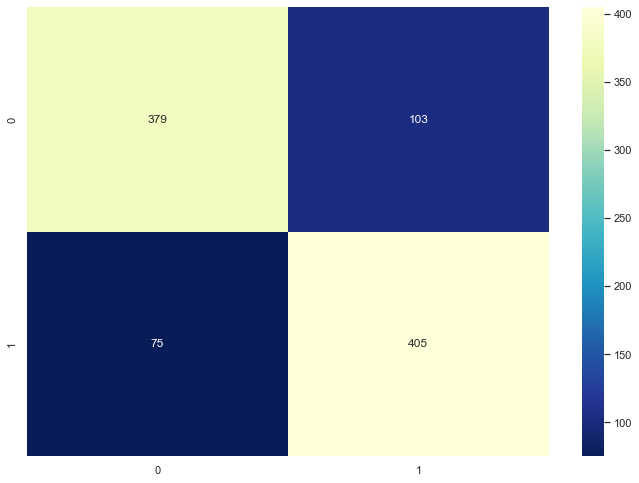

In [59]:

cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

##### GRID SEARCH

In [60]:

# GRID SEARCH FOR 20 COMBINATIONS OF PARAMETERS
grid_list = {"svc__C": np.arange(2, 6, 2),
             "svc__gamma": np.arange(0.1, 0.5, 0.2),
             'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
 
grid_search = GridSearchCV(pipe_svc, param_grid = grid_list, n_jobs = -1,  verbose=0, cv = 5, scoring='recall') 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['travel_with',
                                                                          'purpose',
                                                                          'main_ac

In [61]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_search.best_score_))
print("Best parameters:\n{}".format(grid_search.best_params_))


Best score:
0.87
Best parameters:
{'svc__C': 2, 'svc__gamma': 0.30000000000000004, 'svc__kernel': 'rbf'}


In [62]:
best_model = grid_search.best_estimator_
y_test_predicted = best_model.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.80
Recall: 0.85
Precision: 0.77


In [63]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       482
           1       0.77      0.85      0.81       480

    accuracy                           0.80       962
   macro avg       0.80      0.80      0.79       962
weighted avg       0.80      0.80      0.79       962



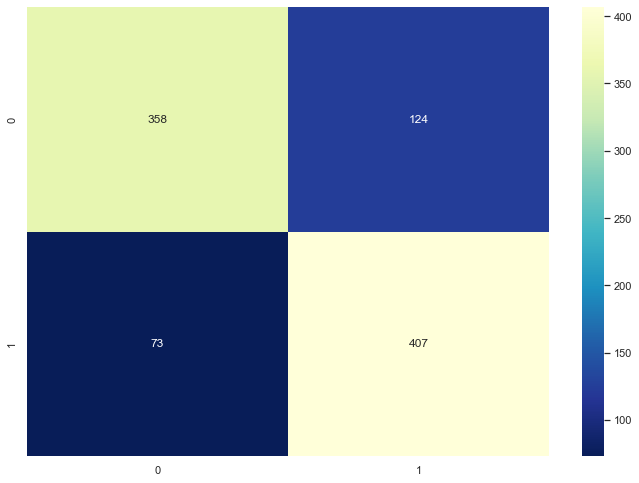

In [64]:
cm = confusion_matrix(y_test, y_test_predicted)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

##### Randomized Search CV

In [65]:
rand_list = {"svc__C": np.arange(2, 6, 2),
             "svc__gamma": np.arange(0.1, 0.5, 0.2),
             'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}
              
rand_search = RandomizedSearchCV(pipe_svc, param_distributions = rand_list, n_iter = 20, n_jobs = -1, cv = 3, random_state = 2017, scoring='recall') 
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer_cat',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='constant')),
                                                                                               ('1hot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['travel_with',
                                                                                'purpose',
                      

In [66]:
# Show best parameters
print('Best score:\n{:.2f}'.format(rand_search.best_score_))
print("Best parameters:\n{}".format(rand_search.best_params_))

Best score:
0.87
Best parameters:
{'svc__kernel': 'rbf', 'svc__gamma': 0.30000000000000004, 'svc__C': 2}


In [67]:
best_model_ran = rand_search.best_estimator_
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted_ran = best_model_ran.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

Accuracy: 0.80
Recall: 0.85
Precision: 0.77


In [68]:
print(classification_report(y_test, y_test_predicted_ran))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       482
           1       0.77      0.85      0.81       480

    accuracy                           0.80       962
   macro avg       0.80      0.80      0.79       962
weighted avg       0.80      0.80      0.79       962



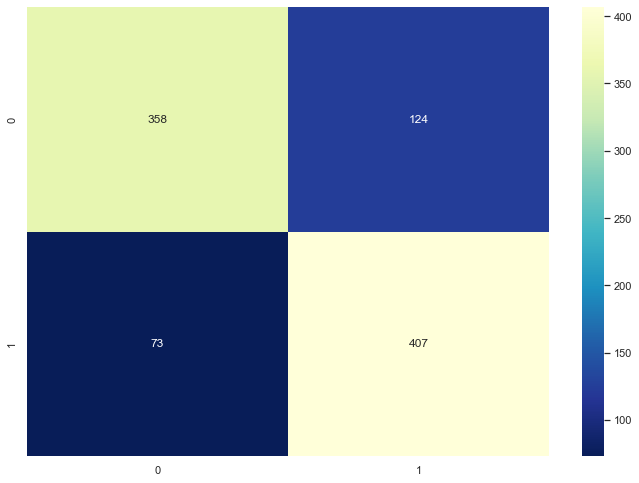

In [69]:
cm = confusion_matrix(y_test, y_test_predicted_ran)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");